In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN

plt.style.use('ggplot')

In [2]:
train_df,test_df = atecml.data.load()
predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
target = 'Fraud'

In [9]:
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

feature_tree_num = 50
if (os.path.exists('./feature_list.dat')):
    print('Load Feature List from persistant store...')
    feature_list = joblib.load('./feature_list.dat')
    
model = {}

gbdt_params = {'boosting_type': 'gbdt',
                      'max_depth': 50,
                      'n_estimators': 100,
                      'use_missing' : True,
                      'categorical_feature': 4,
                      'is_unbalance': True,
                      'seed': 42,
                      'nthread': -1}
goss_params = {'boosting_type': 'goss',
                      'max_depth': 50,
                      'n_estimators': 100,
                      'use_missing' : True,
                      'categorical_feature': 4,
                      'is_unbalance': True,
                      'seed': 42,
                      'nthread': -1}

dart_params = {'boosting_type': 'dart',
                      'max_depth': 50,
                      'n_estimators': 100,
                      'use_missing' : True,
                      'categorical_feature': 4,
                      'is_unbalance': True,
                      'seed': 42,
                      'nthread': -1}

model["GBDT"] = LGBMClassifier(**gbdt_params)
#model["GOSS"] = LGBMClassifier(**goss_params)
#model["DART"] = LGBMClassifier(**dart_params)


Load Feature List from persistant store...


In [10]:
def model_load(model_name):
    model_cache_name = './'+model_name+'.model'
    if (os.path.exists(model_cache_name)):
        clf = joblib.load(model_cache_name)
    else:
        print('ERROR...............')
    return clf
        

In [11]:
train_model =[]
for idx in range(0,1):
    for item in model.keys():
        for feature_grp_idx in range(0,feature_tree_num):
            for target in ['Fraud']:
                train_id = item + '__'+target +'__'+str(idx) +'__' + str(feature_grp_idx)
                train_model.append(train_id)

In [12]:
train_model

['GBDT__Fraud__0__0',
 'GBDT__Fraud__0__1',
 'GBDT__Fraud__0__2',
 'GBDT__Fraud__0__3',
 'GBDT__Fraud__0__4',
 'GBDT__Fraud__0__5',
 'GBDT__Fraud__0__6',
 'GBDT__Fraud__0__7',
 'GBDT__Fraud__0__8',
 'GBDT__Fraud__0__9',
 'GBDT__Fraud__0__10',
 'GBDT__Fraud__0__11',
 'GBDT__Fraud__0__12',
 'GBDT__Fraud__0__13',
 'GBDT__Fraud__0__14',
 'GBDT__Fraud__0__15',
 'GBDT__Fraud__0__16',
 'GBDT__Fraud__0__17',
 'GBDT__Fraud__0__18',
 'GBDT__Fraud__0__19',
 'GBDT__Fraud__0__20',
 'GBDT__Fraud__0__21',
 'GBDT__Fraud__0__22',
 'GBDT__Fraud__0__23',
 'GBDT__Fraud__0__24',
 'GBDT__Fraud__0__25',
 'GBDT__Fraud__0__26',
 'GBDT__Fraud__0__27',
 'GBDT__Fraud__0__28',
 'GBDT__Fraud__0__29',
 'GBDT__Fraud__0__30',
 'GBDT__Fraud__0__31',
 'GBDT__Fraud__0__32',
 'GBDT__Fraud__0__33',
 'GBDT__Fraud__0__34',
 'GBDT__Fraud__0__35',
 'GBDT__Fraud__0__36',
 'GBDT__Fraud__0__37',
 'GBDT__Fraud__0__38',
 'GBDT__Fraud__0__39',
 'GBDT__Fraud__0__40',
 'GBDT__Fraud__0__41',
 'GBDT__Fraud__0__42',
 'GBDT__Fraud__0__43'

In [13]:
trained_model_list =[]
with atecml.data.timer('Classification: Model Training'):
    for train_id in tqdm(range(len(train_model))):
        fit_model = model_load(train_model[train_id])
        trained_model_list.append(fit_model)

  4%|▍         | 2/50 [00:00<00:03, 14.96it/s]

[2018-06-25 17:24:35][Classification: Model Training] Begin ...


100%|██████████| 50/50 [00:01<00:00, 33.67it/s]

[2018-06-25 17:24:37][Classification: Model Training] End   ...[Elapsed: 1.49s]


In [14]:
verify_df = atecml.data.load_train()
verify_data = atecml.data.filter_date(verify_df,start_date='2017-10-16',end_date='2018-10-15')
verify_data.reset_index(drop=True,inplace=True)

In [15]:
verify_df =pd.DataFrame()
verify_proba =pd.DataFrame()
with atecml.data.timer('Validation: Modelfit'):
    for idx in tqdm(range(len(trained_model_list))):
        clf = trained_model_list[idx]
        model_params = train_model[idx].split('__')
        f_idx = int(model_params[3])
        select_feature = feature_list[f_idx]
        y_predict = clf.predict_proba(verify_data[select_feature])
        verify_proba['n1_'+str(idx)] = pd.DataFrame(y_predict)[0]
        verify_proba['n2_'+str(idx)] = pd.DataFrame(y_predict)[1]
        if (model_params[1] == 'Fraud'):
            verify_df[idx] = pd.DataFrame(y_predict)[1]
        else:
            verify_df[idx] = pd.DataFrame(y_predict)[0]

  0%|          | 0/50 [00:00<?, ?it/s]

[2018-06-25 17:24:57][Validation: Modelfit] Begin ...


100%|██████████| 50/50 [01:09<00:00,  1.41s/it]

[2018-06-25 17:26:06][Validation: Modelfit] End   ...[Elapsed: 69.46s]


In [16]:
verify_proba_4dnn = pd.concat([verify_proba,verify_data['Fraud']],axis=1)
verify_proba_4dnn.to_pickle('./verify_proba.dat')
verify_df['mean']=verify_df.T.mean()

0.4781979977753059


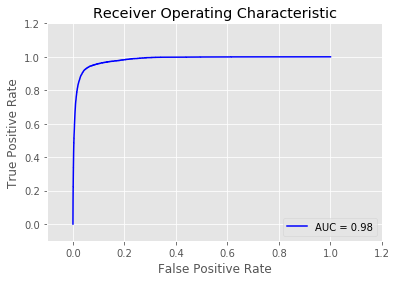

In [17]:
a,b,c=atecml.data.accuracy_validation(verify_data[target],verify_df['mean'])

In [18]:
#build Train_Proba Matrix for DNN:
train_df = atecml.data.load_train()
train_df = atecml.data.filter_date(train_df,start_date='2016-10-16',end_date='2017-10-15')
train_proba =pd.DataFrame()
train_proba_4ana =pd.DataFrame()
with atecml.data.timer('Validation: Modelfit'):
    for idx in tqdm(range(len(trained_model_list))):
        clf = trained_model_list[idx]
        model_params = train_model[idx].split('__')       
        f_idx = int(model_params[3])
        select_feature = feature_list[f_idx]
        y_predict = clf.predict_proba(train_df[select_feature])
        train_proba['n1_'+str(idx)] = pd.DataFrame(y_predict)[0]
        train_proba['n2_'+str(idx)] = pd.DataFrame(y_predict)[1]
        if (model_params[1] == 'Fraud'):
            train_proba_4ana[idx] = pd.DataFrame(y_predict)[1]
        else:
            train_proba_4ana[idx] = pd.DataFrame(y_predict)[0]        

  0%|          | 0/50 [00:00<?, ?it/s]

[2018-06-25 17:26:14][Validation: Modelfit] Begin ...


100%|██████████| 50/50 [02:12<00:00,  2.63s/it]

[2018-06-25 17:28:26][Validation: Modelfit] End   ...[Elapsed: 132.50s]


In [19]:
train_proba_4dnn = pd.concat([train_proba,train_df['Fraud']],axis=1)
train_proba_4dnn.to_pickle('./train_proba.dat')

In [20]:
test_df = atecml.data.load_test()
predict_df =pd.DataFrame()
predict_probaDNN =pd.DataFrame()
with atecml.data.timer('Prediction: Modelfit'):
    for idx in tqdm(range(len(trained_model_list))):
        clf = trained_model_list[idx]
        model_params = train_model[idx].split('__')
        f_idx = int(model_params[3])
        select_feature = feature_list[f_idx]
        y_predict = clf.predict_proba(test_df[select_feature])
        predict_probaDNN['n1_'+str(idx)] = pd.DataFrame(y_predict)[0]
        predict_probaDNN['n2_'+str(idx)] = pd.DataFrame(y_predict)[1]        
        if (model_params[1] == 'Fraud'):
            predict_df[idx] = pd.DataFrame(y_predict)[1]
        else:
            predict_df[idx] = pd.DataFrame(y_predict)[0]
            
predict_probaDNN.to_pickle('./test_proba.dat')            

  0%|          | 0/50 [00:00<?, ?it/s]

[2018-06-25 17:28:31][Prediction: Modelfit] Begin ...


100%|██████████| 50/50 [01:36<00:00,  1.87s/it]


[2018-06-25 17:30:08][Prediction: Modelfit] End   ...[Elapsed: 96.81s]


In [35]:
new_train_df = pd.concat([train_proba_4dnn,train_df[predictors]],axis=1)

In [44]:
params = {'boosting_type': 'gbdt',
               'n_estimators': 500,
               'use_missing' : True,
               'categorical_feature': 0,
               'is_unbalance': True,
               'max_depth': -1,
               'num_leaves': 80,
               'learning_rate': 0.05,
               'max_bin': 512,
               'subsample_for_bin': 200,
               'subsample': 0.8,
               'subsample_freq': 1,
               'colsample_bytree': 0.8,
               'reg_alpha': 5,
               'reg_lambda': 10,
               'min_split_gain': 0.5,
               'min_child_weight': 1,
               'min_child_samples': 5,
               'scale_pos_weight': 1,
               'num_class' : 1,
               'metric' : 'binary_error',
               'seed': 42,
               'nthread': -1
              }

summary_model = LGBMClassifier(**params)
sum_predictors = [x for x in new_train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
target = 'Fraud'

In [50]:
summary_model.fit(new_verify_df[sum_predictors],verify_data[target])

LGBMClassifier(boosting_type='gbdt', categorical_feature=0, class_weight=None,
        colsample_bytree=0.8, is_unbalance=True, learning_rate=0.05,
        max_bin=512, max_depth=-1, metric='binary_error',
        min_child_samples=5, min_child_weight=1, min_split_gain=0.5,
        n_estimators=500, n_jobs=-1, nthread=-1, num_class=1,
        num_leaves=80, objective=None, random_state=None, reg_alpha=5,
        reg_lambda=10, scale_pos_weight=1, seed=42, silent=True,
        subsample=0.8, subsample_for_bin=200, subsample_freq=1,
        use_missing=True)

In [51]:
new_verify_df = pd.concat([verify_proba_4dnn,verify_data[predictors]],axis=1)

In [52]:
y_predict = summary_model.predict_proba(new_verify_df[sum_predictors])

0.9498109010011124


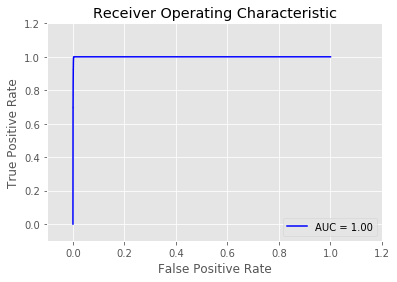

In [53]:
a,b,c=atecml.data.accuracy_validation(verify_data[target],pd.DataFrame(y_predict)[1])

In [55]:
new_test_df = pd.concat([predict_probaDNN,test_df[predictors]],axis=1)
result_proba = summary_model.predict_proba(new_test_df[sum_predictors])
result = pd.DataFrame()
result['id'] = test_df['id']
result['score'] = pd.DataFrame(result_proba)[1]
result.set_index('id').to_csv('./submit_20180625_5.csv')    

In [ ]:
import random


In [ ]:
feature_list = {}
for idx in range(0,1000):
    feature_list[idx] = random.sample(predictors,20)

In [ ]:
joblib.dump(feature_list,'./feature_list')

In [ ]:
a = joblib.load('./feature_list')

In [ ]:
a[1] == feature_list[1]